In [1]:
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(ROOT_DIR)

from utils.utils import mse

from utils.problem import MitsubaProblem
from utils.problems.bunny import BunniesProblem

from utils.global_opt.grad import GlobalOptGrad, RandomStartGrad
from utils.global_opt.utils import IterationStoppingCriteria, NotImprovingStoppingCriteria

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.de import DE

mi.set_variant('cuda_ad_rgb')

In [2]:
single_bunny_pb = BunniesProblem(nb_bunnies=1, colored=False)

In [3]:
img_ref, bm_ref = single_bunny_pb.render(seed=0, spp=1024)
bm_ref

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [4]:
loss_fn = lambda img: mse(img, img_ref)
global_opt_grad = GlobalOptGrad(single_bunny_pb)
random_start_grad = RandomStartGrad(single_bunny_pb)

In [5]:
def plot_final_result(res, losses: dict, pb: MitsubaProblem, title=None):
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))

    axs[0].imshow(pb.render_individual(res.X, spp=1024)[1])
    axs[0].axis('off')
    axs[0].set_title('Optimized image')

    axs[1].imshow(mi.util.convert_to_bitmap(img_ref))
    axs[1].axis('off')
    axs[1].set_title('Reference Image')
    
    # plot loss
    for name, loss in losses.items():
        axs[2].plot(loss, label=name)
    axs[2].set_title('Loss')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Loss')

    if title is not None:
        fig.suptitle(title, fontsize=16)

    plt.legend()
    plt.show()

In [6]:
def random_start_exp(pop_size, max_iter, seed=0):
    res, losses, nb_renderings = random_start_grad.run(
        loss_fn,
        pop_size=pop_size,
        grad_descent_stopping_criteria=IterationStoppingCriteria(max_iter=max_iter),
        lr=0.025,
        spp=16,
        seed=seed,
        verbose=True,
    )
    losses_dict = {f"{i}" : losses[i] for i in range(len(losses))}
    plot_final_result(res, losses_dict, single_bunny_pb, title=f'Random start: {pop_size=}, grad_descent={max_iter} - {nb_renderings=}')

In [7]:
def ga_grad_exp(pop_size, n_gen, max_iter, seed=0):
    res, losses, nb_renderings = global_opt_grad.run(
        GA(pop_size=pop_size, eliminate_duplicates=True),
        loss_fn,
        n_gen=n_gen,
        grad_descent_stopping_criteria=IterationStoppingCriteria(max_iter),
        lr=0.025,
        spp=16,
        seed=seed,
        verbose=True,
    )
    losses_dict = {
        "avg" : [np.mean(l) for l in losses],
        "best" : [np.min(l) for l in losses],
        "worst" : [np.max(l) for l in losses],
    }
    plot_final_result(res, losses_dict, single_bunny_pb, title=f'Genetic algorithm: {pop_size=}, {n_gen=}, grad_descent={max_iter}  - {nb_renderings=}')


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



[Ind. 1/1] Grad step 199	Best loss: 0.002678	Nb renderings: 199: : 1it [00:49, 49.21s/it]


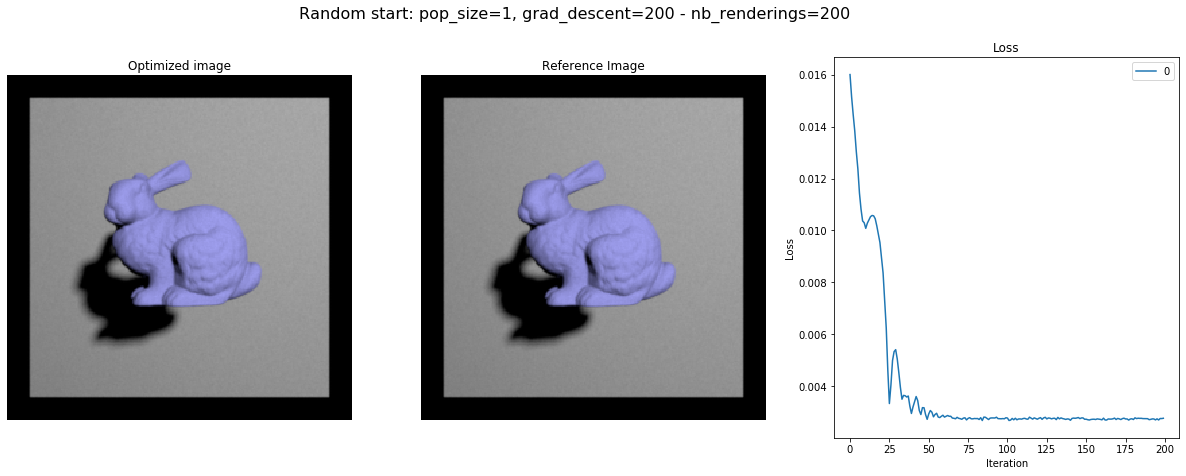

In [8]:
random_start_exp(pop_size=1, max_iter=200, seed=0)

[Ind. 1/1] Grad step 199	Best loss: 0.008155	Nb renderings: 199: : 1it [00:51, 51.49s/it]


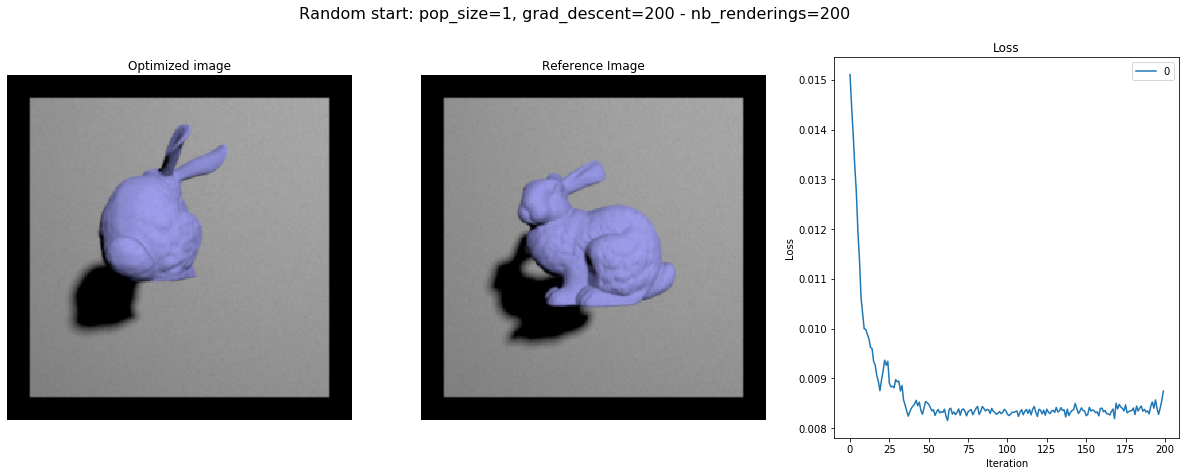

In [9]:
random_start_exp(pop_size=1, max_iter=200, seed=1)

[Ind. 1/1] Grad step 199	Best loss: 0.015158	Nb renderings: 199: : 1it [00:47, 47.87s/it]


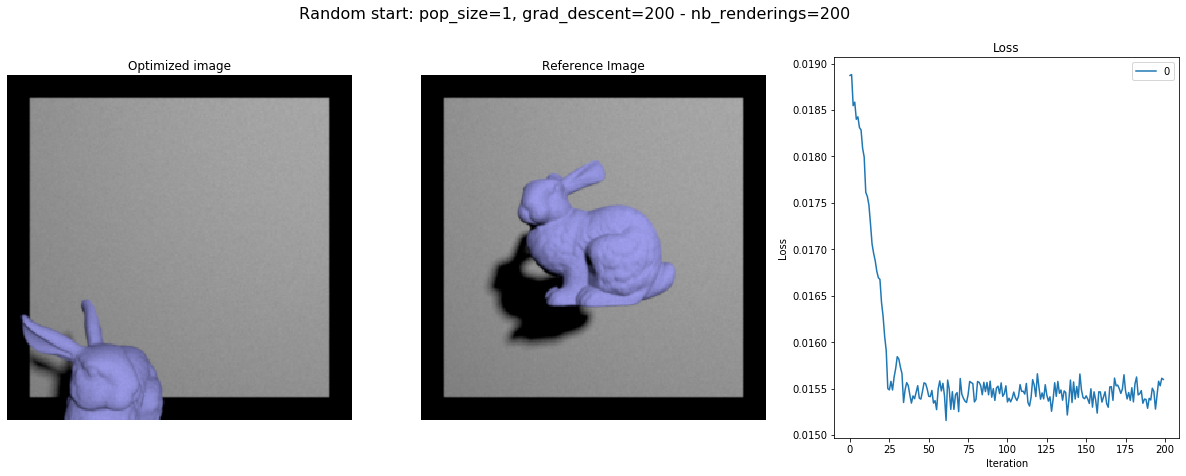

In [10]:
random_start_exp(pop_size=1, max_iter=200, seed=2)

[Ind. 5/5] Grad step 39	Best loss: 0.002710	Nb renderings: 199: : 5it [00:56, 11.29s/it]


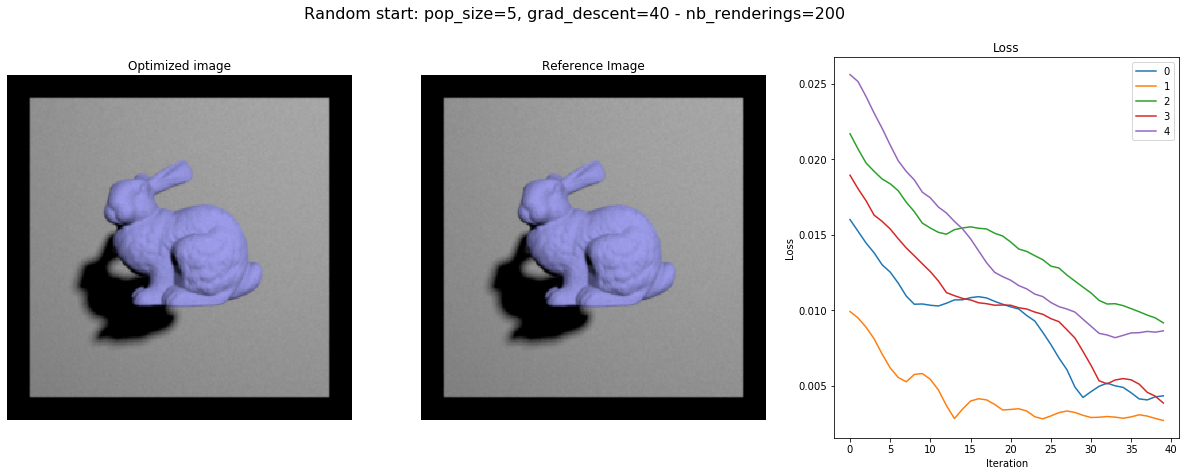

In [11]:
random_start_exp(pop_size=5, max_iter=40)

[Gen. 10/10] Ind. 20/20	Best loss: 0.002870	Nb renderings: 199: 100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


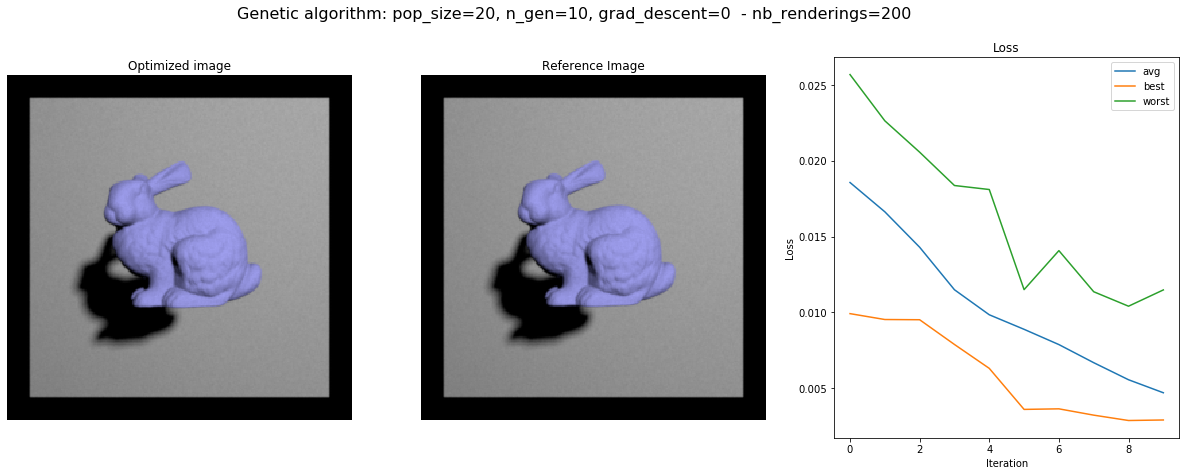

In [12]:
ga_grad_exp(pop_size=20, n_gen=10, max_iter=0)

[Gen. 4/4] Ind. 10/10	Best loss: 0.002930	Nb renderings: 199: 100%|██████████| 4/4 [00:49<00:00, 12.41s/it]


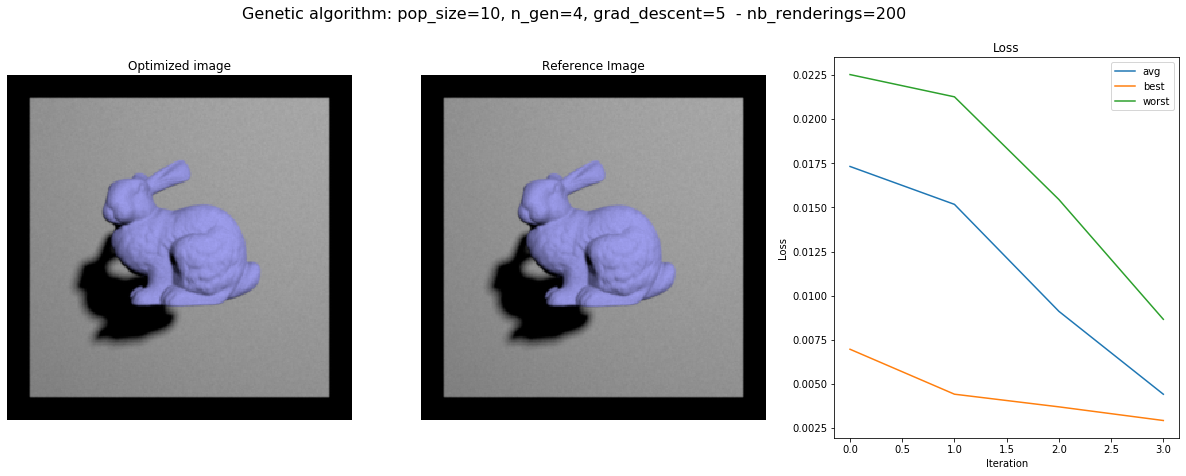

In [13]:
ga_grad_exp(pop_size=10, n_gen=4, max_iter=5)